James Ho
Olivia Seitelman

Question?
How would the world population be different today if the Green Revolution had never occurred?

Model:
Build a model that fits the population growth before the green revolution (roughly in the 1960's). Extrapolate this model to the present year. This plot can then be compared to the actual population data.

In [ ]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html
import pandas
import numpy as np
from numpy import genfromtxt

In [ ]:
# Import the .csv files of the population data
my_data = pandas.read_csv('WorldPopData.csv', sep=',');

In [ ]:
# Will modify this function later to plot the model and the data
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [ ]:
# Converts data to array
year = my_data.year.values;
pop = my_data.WorldPop.values;

# Cut the data to start from 1900
# Population will be in billions
year1900 = my_data.year.values[11900:12018];
pop1900 = my_data.WorldPop.values[11900:12018]/10**9;

In [ ]:
# Test plotting the data
plot(year1900, pop1900)

In [ ]:
t_0 = year1900[0]
t_end = year1900[-1]
elapsed_time = t_end - t_0

p_0 = pop1900[0]
p_end = pop1900[-1]
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

In [ ]:
# Model System object
modelSystem = System(t_0 = t_0,
                    t_end = t_end,
                    p_0 = p_0,
                    annual_growth = annual_growth,
                    birth_rate = 0.02,
                    death_rate = 0.011,
                    alpha = 0.014,
                    beta = -0.003,
                    gamma = -0.00005)

In [ ]:
# Run simulation
def run_sim(system, update_func):
    """Simulate the system using any update function
    system: System object
    update_func: function that computes the population next year
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], system)
    return results

In [ ]:
# Update function: Proportional growth
def update_proportional(pop, system):
    """update function with proportional growth.
    
    system: System object
    pop: the current population
    returns: returns the new population
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    result = births - deaths + pop
    return result

In [ ]:
population = run_sim(modelSystem, update_proportional);

In [ ]:
plot(population)
plot(year1900, pop1900)

In [ ]:
# Update function: Quadratic growth
def update_quadratic(pop, system):
    """udpate function with proportional growth.
    
    system: System object
    pop: the current population
    returns: returns the new population
    """
    netGrowth = system.alpha * pop + system.beta * pop**2
    result = netGrowth + pop
    return result
    

In [ ]:
update_quadratic(1200,modelSystem)

In [ ]:
population = run_sim(modelSystem, update_quadratic);

In [ ]:
plot(population)
plot(year1900, pop1900)

In [ ]:
# Update function: polynomial growth
def update_poly(pop, system):
    """udpate function with proportional growth.
    
    system: System object
    pop: the current population
    returns: returns the new population
    """
    netGrowth = system.alpha * pop + system.beta * pop**2 + system.gamma * pop**3
    result = netGrowth + pop
    return result

In [ ]:
# Use numpy polyfit to find the correct coefficient
coeff = np.polyfit(year1900, pop1900,3)

In [ ]:
population = run_sim(modelSystem, update_poly);

In [ ]:
plot(population)
plot(year1900, pop1900)

In [ ]:
growthRate1900 = np.diff(pop1900);

In [ ]:
pop1900[-1]

In [ ]:
plot(year1900[:-1], growthRate1900)


In [ ]:
growthRate1900[60]

In [ ]:
# Test code for gradient descent and random stuff

In [224]:
def cost_func(time, realPop, weight, bias):
    n = len(time)
    total_error = 0.0
    for i in range(n):
        total_error += (realPop[i] + (weight*time[i] + bias))**2
    return total_error / n

In [222]:
def update_weights(time, realPop, weight, bias, learning_rate):
    weight_deriv = 0
    bias_deriv = 0
    n = len(time)

    for i in range(n):
        # Calculate partial derivatives
        # -2x(y - (mx + b))
        weight_deriv += -2*time[i] * (realPop[i] - (weight*time[i] + bias))

        # -2(y - (mx + b))
        bias_deriv += -2*(realPop[i] - (weight*time[i] + bias))

    # We subtract because the derivatives point in direction of steepest ascent
    weight -= (weight_deriv / n) * learning_rate
    bias -= (bias_deriv / n) * learning_rate

    return weight, bias

In [1]:
def gradient_descent():
    newWeight = 0;
    newBias = 0;
    learningRate = 0.0001;
    newParams = update_weights(year1900, pop1900, newWeight, newBias, learningRate);
    newWeight = newParams[0];
    newBias = newParams

In [262]:
update_weights(year1900, pop1900, modelSystem.weight, 0, 0.000001)

(-0.07926292472574188, -4.768566326760345e-05)

In [266]:
cost_func(year1900, pop1900, modelSystem.weight-0.07926292472574188, 0)

15423.66133101163

In [259]:
# Model System object
modelSystem = System(t_0 = t_0,
                    t_end = t_end,
                    p_0 = p_0,
                    annual_growth = annual_growth,
                    birth_rate = 0.02,
                    death_rate = 0.011,
                    alpha = 0.014,
                    beta = -0.003,
                    gamma = -0.00005,
                    weight = 0.014)

,values
t_0,1900.000000
t_end,2015.000000
p_0,1.650000
annual_growth,0.049561
birth_rate,0.020000
death_rate,0.011000
alpha,0.014000
beta,-0.003000
gamma,-0.000050
weight,0.014000


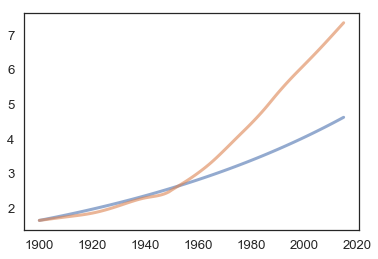

In [249]:
population = run_sim(modelSystem, update_proportional);
plot(population)
plot(year1900, pop1900)